In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

print("all libraries installed successfully")

all libraries installed successfully


In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumanthnimmagadda/student-spending-dataset")

print("Path to dataset files:", path)

df = pd.read_csv(r'C:\Users\azama\.cache\kagglehub\datasets\sumanthnimmagadda\student-spending-dataset\versions\1\student_spending (1).csv')

Path to dataset files: C:\Users\azama\.cache\kagglehub\datasets\sumanthnimmagadda\student-spending-dataset\versions\1


In [23]:
display(df.head())
print(df.info())
print(df.describe())
print(df.isna().sum())

,Unnamed: 0,age,gender,year_in_school,major,monthly_income,financial_aid,tuition,housing,food,transportation,books_supplies,entertainment,personal_care,technology,health_wellness,miscellaneous,preferred_payment_method
0,0,19,Non-binary,Freshman,Psychology,958,270,5939,709,296,123,188,41,78,134,127,72,Credit/Debit Card
1,1,24,Female,Junior,Economics,1006,875,4908,557,365,85,252,74,92,226,129,68,Credit/Debit Card
2,2,24,Non-binary,Junior,Economics,734,928,3051,666,220,137,99,130,23,239,112,133,Cash
3,3,23,Female,Senior,Computer Science,617,265,4935,652,289,114,223,99,30,163,105,55,Mobile Payment App
4,4,20,Female,Senior,Computer Science,810,522,3887,825,372,168,194,48,71,88,71,104,Credit/Debit Card


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                1000 non-null   int64 
 1   age                       1000 non-null   int64 
 2   gender                    1000 non-null   object
 3   year_in_school            1000 non-null   object
 4   major                     1000 non-null   object
 5   monthly_income            1000 non-null   int64 
 6   financial_aid             1000 non-null   int64 
 7   tuition                   1000 non-null   int64 
 8   housing                   1000 non-null   int64 
 9   food                      1000 non-null   int64 
 10  transportation            1000 non-null   int64 
 11  books_supplies            1000 non-null   int64 
 12  entertainment             1000 non-null   int64 
 13  personal_care             1000 non-null   int64 
 14  technology               

In [26]:
# select featuers
X = df.drop(['Unnamed: 0', 'age', 'gender', 'year_in_school', 'major', 'preferred_payment_method'], axis=1)

# standardize features

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

# apply pca

pca = PCA()
Xpca = pca.fit_transform(Xscaled)

# explained variance
explainedVariance = pca.explained_variance_ratio_
cumulativeVariance = explainedVariance.cumsum()

print("Explained Variance:", explainedVariance)
print("Cumulative Variance:", cumulativeVariance)

# choose number of components
n_components = (cumulativeVariance < 0.95).sum() + 1
print("Number of components to retain 95% variance:", n_components)

# fit pca with n_components
pcaFinal = PCA(n_components=n_components)
XpcaFinal = pcaFinal.fit_transform(Xscaled)

print('Reduced data: \n', XpcaFinal)

# Component Loading
loadings = pd.DataFrame(
    pcaFinal.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X.columns
)

print("PCA Loadings:\n", loadings)


Explained Variance: [0.09371291 0.09136103 0.09002188 0.08793671 0.08643187 0.08461883
 0.08371983 0.08026862 0.07958701 0.07852012 0.07361978 0.0702014 ]
Cumulative Variance: [0.09371291 0.18507394 0.27509582 0.36303253 0.4494644  0.53408323
 0.61780306 0.69807168 0.77765869 0.85617882 0.9297986  1.        ]
Number of components to retain 95% variance: 12
Reduced data: 
 [[-0.40328435 -0.45771397 -1.51815261 ...  1.21087727  0.39011646
   0.17875991]
 [ 1.70347329  0.05669039 -1.26486077 ...  0.71451261 -0.05940947
   1.17619819]
 [-0.15678749  0.33021262  1.24975401 ... -1.27642163 -1.0331699
  -1.06158562]
 ...
 [ 1.09059167  0.35843496  1.32596793 ... -0.06740575 -0.5663291
  -2.32777868]
 [ 1.22065164  0.78635205  0.62879579 ... -0.47902865 -0.36455565
   0.95005533]
 [ 0.64090472  0.03482572 -0.72070686 ... -0.36321801 -0.82823086
  -0.03232488]]
PCA Loadings:
                       PC1       PC2       PC3       PC4       PC5       PC6  \
monthly_income   0.070189  0.495557  0.18

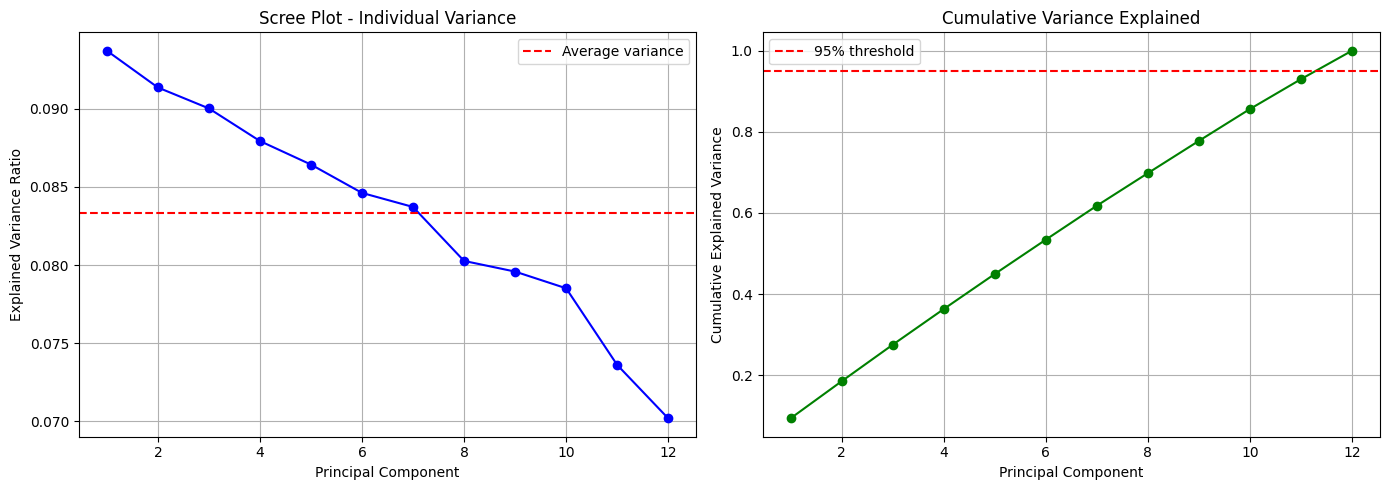


Conclusion: Each component explains ~8.3% variance on average.
The relatively flat scree plot indicates features are NOT highly correlated.
Dimensionality reduction from 12 to 12 components retains 95% variance,
but this represents minimal reduction, suggesting PCA may not be very beneficial here.


In [ ]:
# THE BELOW VISUALIZATION IS DONE USING LLMS

# Scree plot - showing both individual and cumulative variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance (true scree plot)
ax1.plot(range(1, len(explainedVariance)+1), explainedVariance, 'bo-')
ax1.axhline(y=1/len(explainedVariance), color='r', linestyle='--', label='Average variance')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot - Individual Variance')
ax1.grid(True)
ax1.legend()

# Cumulative explained variance
ax2.plot(range(1, len(explainedVariance)+1), cumulativeVariance, 'go-')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance Explained')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nConclusion: Each component explains ~{explainedVariance.mean():.1%} variance on average.")
print(f"The relatively flat scree plot indicates features are NOT highly correlated.")
print(f"Dimensionality reduction from 12 to {n_components} components retains 95% variance,")
print(f"but this represents minimal reduction, suggesting PCA may not be very beneficial here.")